In [64]:
import os
import pandas as pd
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix, 
    roc_auc_score,
    precision_score,
    recall_score
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV


# (a) Dataset Exploration #

Since this is an image based dataset, the exploration is limited to the size of the images and the number of samples for each classification. All of the images are of the same size and type (.jpg). When calculating the number of samples, we can see that we have 454 samples, with 337 being classified as "0" which indicates no glaucoma and 117 being "1" meaning glaucoma is present.


In [65]:
df_train = pd.read_csv("/Users/parshvamehta/ece539-final/data/origa-dataset/ORIGA_train.csv")
df_test = pd.read_csv("/Users/parshvamehta/ece539-final/data/origa-dataset/ORIGA_test.csv")

TRAIN_DIR = "/Users/parshvamehta/ece539-final/data/origa-dataset/ORIGA/train"
TEST_DIR = "/Users/parshvamehta/ece539-final/data/origa-dataset/ORIGA/test"

print("Columns:", df_train.columns.tolist())
df_train.head()

num_samples = len(df_train)
print(f"Total labeled samples: {num_samples}")

label_counts = df_train['glaucoma'].value_counts().sort_index()

print("Label counts:")
print(label_counts)

print("Missing values per column:")
print(df_train.isna().sum())

Columns: ['ImageName', 'glaucoma']
Total labeled samples: 454
Label counts:
glaucoma
0    337
1    117
Name: count, dtype: int64
Missing values per column:
ImageName    0
glaucoma     0
dtype: int64


# (b) Dataset Preprocessing / (c) Feature Extraction (PCA) #
The dataset comes with a premade test split, which we will use for comparison purposes at the end of this notebook. The train dataset, although fairly small- must be split into training and validation sets in order to ensure we do not overfit to the training data. The dataset is also imbalanced, with non glaucoma samples far exceeding the number of glaucoma samples. This is fairly common in medical datasets. 

The sqaure images are loaded with their native dimension being approximately (by inspection) 330px to 450px. This is relatively small to begin with and while many object detection algorithms use grayscale imaging, I believe that medical datasets (such as this one) may need the color information which is why we convert the images to all be 64px tall and wide and in RGB. This reduces the size of the data leading to significantly faster training, without losing key information. 


In [66]:

train_df, val_df = train_test_split(
    df_train,
    test_size=0.2,
    stratify=df_train['glaucoma'],
    random_state=42,
)

print("Train samples:", len(train_df))
print("Val samples:", len(val_df))

print("\nTrain label distribution:")
print(train_df['glaucoma'].value_counts(normalize=True))

print("\nVal label distribution:")
print(val_df['glaucoma'].value_counts(normalize=True))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

IMG_SIZE = 64

print("\nPCA reduced train feature matrix shape:", X_train.shape)
print("PCA reduced val feature matrix shape:", X_val.shape)

def load_images_as_vectors(df, img_dir, img_size=64):
    X_list = []
    y_list = []

    for _, row in df.iterrows():
        raw_name = row["ImageName"]
        img_name = os.path.basename(str(raw_name))
        label = int(row["glaucoma"])

        img_path = os.path.join(img_dir, img_name)
        if not os.path.exists(img_path):
            continue

        img = Image.open(img_path).convert("RGB")
        img = img.resize((img_size, img_size))
        arr = np.array(img, dtype=np.float32) / 255.0
        vec = arr.flatten()

        X_list.append(vec)
        y_list.append(label)

    if not X_list or not y_list:
        raise ValueError("No images were loaded. Check image paths and filenames.")

    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=np.int64)
    return X, y

X_train, y_train = load_images_as_vectors(train_df, TRAIN_DIR, img_size=IMG_SIZE)
X_val,   y_val   = load_images_as_vectors(val_df,   TRAIN_DIR, img_size=IMG_SIZE)

print("\nTrain feature matrix shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Val feature matrix shape:", X_val.shape)
print("Val labels shape:", y_val.shape)

pca = PCA(n_components=0.95, random_state=42)
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)

print("\nAfter PCA")
print("Train feature matrix shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Val feature matrix shape:", X_val.shape)
print("Val labels shape:", y_val.shape)

Train samples: 363
Val samples: 91

Train label distribution:
glaucoma
0    0.741047
1    0.258953
Name: proportion, dtype: float64

Val label distribution:
glaucoma
0    0.747253
1    0.252747
Name: proportion, dtype: float64

PCA reduced train feature matrix shape: (363, 78)
PCA reduced val feature matrix shape: (91, 78)

Train feature matrix shape: (363, 12288)
Train labels shape: (363,)
Val feature matrix shape: (91, 12288)
Val labels shape: (91,)

After PCA
Train feature matrix shape: (363, 78)
Train labels shape: (363,)
Val feature matrix shape: (91, 78)
Val labels shape: (91,)


# (d) Machine Learning Method 1: Logistic Regression #

Logisitc Regression is a classifier that uses the pre-processed dataset to detect the presence of glaucoma. The model uses L2 regularization to prevent overfitting and adds class weights as the number of samples that depict glaucoma are far less than normal eye samples. Logistic regression models the probability that Y = 1 using a sigmoid function on a flattened vector of pixel intensities. This essentially learns a hyperplane in a high dimensional feature space. The model learns using a regularized log-loss function that penalizes misclassifications proportinally to how confident the model is. 

The parameters for this modela are tuned by a grid search over different values for solver, C and class weight. Since many of the features are correlated, I chose to use L2 regularization as it is generally better for highly correlated features. The API for this function mentions that lbfgs is a good default solver for most tasks, however I also read that liblinear does well for small datasets. Since this is a small dataset, I decided to include it in the sweep to test which ones are better. The retina images contain a large amount of correlated features which is why we use L2 regularization that penalizes large weight value by scaling them by the squared magnitude of the weights.

We measure the accuracy, macro F1 score and plot the confusion matrix. This model achieved a respectable accuracy of 82.4%. The F1 score for class 1 is still pretty low at 0.67 which is likely due to the loss of spatial information when we flatten the image. This is particularly beneficial in the medical field as the output of logistic regression is a prediction of probability rather than simply minimizing a loss value. 

In [67]:

log_reg = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=5000,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

param_grid = {
    "penalty": ["l2"],
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["liblinear", "lbfgs"],
    "max_iter": [1000],
    "class_weight": [None, "balanced"]
}

grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)
log_reg = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

log_reg.fit(X_train, y_train)
y_val_pred = log_reg.predict(X_val)
y_val_proba = log_reg.predict_proba(X_val)[:, 1]

def evaluate_logreg(X, y_true, model):
    y_pred = model.predict(X)

    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4, output_dict=True)
    return acc, f1_macro, cm, report, y_true, y_pred


Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


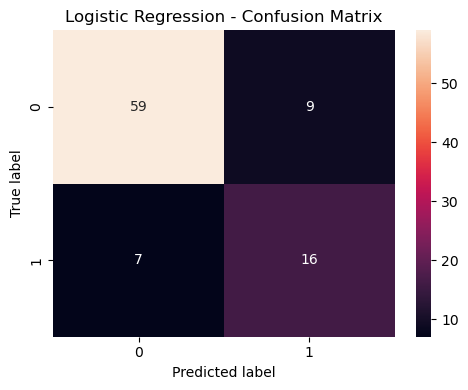

Classification Report
              precision  recall  f1-score
0                 0.894   0.868     0.881
1                 0.640   0.696     0.667
accuracy          0.824   0.824     0.824
macro avg         0.767   0.782     0.774
weighted avg      0.830   0.824     0.827


In [68]:
acc, f1_macro, cm, report, y_true, y_pred = evaluate_logreg(X_val, y_val, log_reg)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=[0, 1],
    yticklabels=[0, 1]
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Logistic Regression - Confusion Matrix")
plt.tight_layout()
plt.show()

print("Classification Report")
df_report = pd.DataFrame(report).T.round(3)
df_report = df_report.drop(columns=["support"], errors="ignore")  # example tweak
print(df_report)

# Machine Learning Method 2: SVM Classifier #

Support Vector Machines (SVMs) were also applied to the pre-processed dataset to detect the presence of glaucoma. Instead of modeling probabilities directly, the SVM attempts to find a maximum-margin hyperplane in the high-dimensional pixel space that best separates healthy and glaucomatous retina images. This margin-based approach is often effective in high-dimensional settings, as the decision boundary depends primarily on the support vectors—the most informative samples near the class boundary. In a linear SVM, the model learns a single separating hyperplane similar to Logistic Regression, but it optimizes a hinge loss rather than a probabilistic objective.

The retina images contain a large number of correlated features due to the flattening process, and while SVMs can handle multicollinearity implicitly through margin maximization, they still struggle when spatial structure is lost. Consequently, the model achieved a lower overall accuracy of 74.7%. The F1 score for the glaucoma class remained low at 0.53, reflecting both the class imbalance and the difficulty of separating complex retinal patterns using a linear margin-based model. The confusion matrix shows that the SVM misclassified a substantial number of glaucoma cases as normal. The loss of spatial structure affected the SVM far greater than the logistic regression classifier. 

The parameters for SVC are the Kernel, penalty factor, kernel coefficient (gamma) and class weighting. I used a Grid Search once again to find the optimal parameters due to the large number of changes that can be made. The kernel of an SVC/SVM is the function that raises the data to a higher dimensional space to find a linear seperator in this new space. The options from skikit-learn.org are linear (which is equivalent to no transformation), polynomial, radial base function and sigmoid- all kernels that we have gone over in class. The value of C in the grid search goes from 0.1 to 100 by orders of 10 to find if a lower penalty term or a higher penalty term benefits the model. A high C value will risk overfitting the data. The gamma parameter is specific to the RBF, Polynomial and sigmoid kernel, it defines the max distance at which a training value has influence on the model. The default value divides 1/ number of features * variance and "auto" simply divides 1/number of features. I used geeks-for-geeks to fully understand the tradeoff between a high value of gamma vs small value. A high value will limit the influence to a small reigion, giving high localized accuracy but bad generalization. A low value will lead to smooth decision boundries and a high bias, leading to underfitting. 

The default value sets this parameter as the inverse of the number of features, whereas scale multiplies that value by the variance leading to better classificatiob by reducing bias. 

In [76]:
svm = SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        class_weight="balanced",
        random_state=42,
    )

param_grid_svm = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", "auto"],
    "class_weight": [None, "balanced"]
}

grid_search_svm = GridSearchCV(
    SVC(),
    param_grid_svm,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
)

grid_search_svm.fit(X_train, y_train)
svm = grid_search_svm.best_estimator_
print("Best parameters for SVM:", grid_search_svm.best_params_)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_val)

def evaluate_svm(X, y_true, model):
    y_pred = model.predict(X)

    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4, output_dict=True)

    return acc, f1_macro, cm, report, y_true, y_pred

Best parameters for SVM: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}


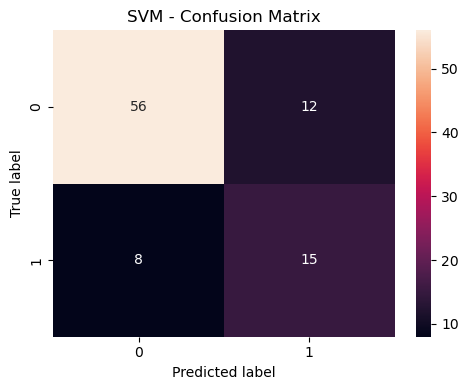

              precision  recall  f1-score
0                 0.875   0.824     0.848
1                 0.556   0.652     0.600
accuracy          0.780   0.780     0.780
macro avg         0.715   0.738     0.724
weighted avg      0.794   0.780     0.786


In [70]:
acc, f1_macro, cm, report, y_true, y_pred = evaluate_svm(X_val, y_val, svm)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=[0, 1],
    yticklabels=[0, 1]
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("SVM - Confusion Matrix")
plt.tight_layout()
plt.show()


df_report = pd.DataFrame(report).T.round(3)
df_report = df_report.drop(columns=["support"], errors="ignore")
print(df_report)

# (e) Logistic Regression vs Support Vector Machine

Logistic regression (LR) achieves a higher overall accuracy of 84.6% vs SVM at 78.0%, as well as a stronger macro-f1 score of 0.774 vs 0.724. This is seen most clearly in the confusion matrix where LR has a much higher error in predicting Y = 1 (Glaucoma) as well as failing to predict correctly. The ROC while similar, also turns in the LR classifier's favor. This is a sign that the accuracy metric of the SVM is misleadingly high due to the imbalance of the dataset. Since the majority of the dataset is cases where Y = 0, simply predicting samples to be non-glaucoma can lead to high levels of accuracy. This is the reason for the lowered recall score and why its important to rely on many different metrics rather than just pure accuracy. 

Computationally, Logistic Regression is more practical in the medical sense, since using cross-entropy or log-loss function directly translates loss to probability which helps in the interpretabiltiy of the results. For example, P(Y=1)/P(Y=0) in this situation represents the odds that an individual has glaucoma, given that the dataset correctly models the overall population.

This assumption may also be a reason for the lowered accuracy numbers as this dataset is quite small. Although it may correctly model the proportion of people that suffer from glaucoma vs. healthy eyes, it simply does not have the volume to be considered a good population model. There are only 91 validation samples, which make the ROC curve look more like a stairwell than an actual curve. Despite this, the LR curve wins out early with a higher TPR at a lower FPR. 

Another consideration is the number of parameters involved in both models. The SVM required many more parameters which increased time for tuning making Logistic regression the more simple model to interpret as well.

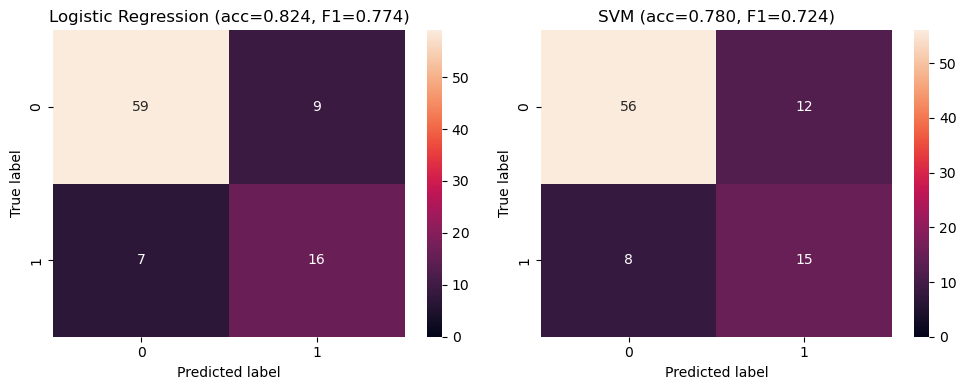

In [71]:
acc_lr,  f1_lr,  cm_lr,  report_lr,  y_true_lr,  y_pred_lr  = evaluate_logreg(X_val, y_val, log_reg)
acc_svm, f1_svm, cm_svm, report_svm, y_true_svm, y_pred_svm = evaluate_svm(X_val, y_val, svm)

class_names = [0, 1]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Logistic Regression
sns.heatmap(
    cm_lr,
    annot=True,
    fmt="d",
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axes[0],
    vmin=0,
)
axes[0].set_title(f"Logistic Regression (acc={acc_lr:.3f}, F1={f1_lr:.3f})")
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("True label")

# SVM
sns.heatmap(
    cm_svm,
    annot=True,
    fmt="d",
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axes[1],
    vmin=0,
)
axes[1].set_title(f"SVM (acc={acc_svm:.3f}, F1={f1_svm:.3f})")
axes[1].set_xlabel("Predicted label")
axes[1].set_ylabel("True label")

plt.tight_layout()
plt.show()


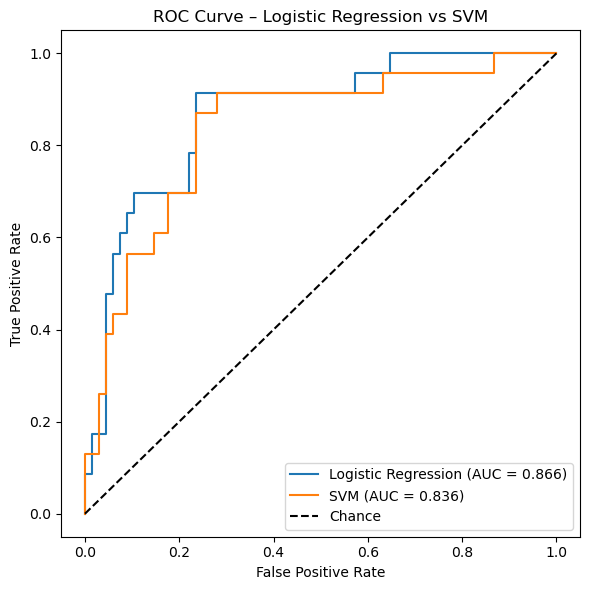

In [72]:
plt.figure(figsize=(6, 6))

for model, name in [(log_reg, "Logistic Regression"), (svm, "SVM")]:
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_val)[:, 1]
    else:
        y_score = model.decision_function(X_val)
    fpr, tpr, _ = roc_curve(y_val, y_score) 
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression vs SVM")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


# (f) Ethical Issues

The main ethical concern for this dataset would be in the collection of data samples. Since this is a human body part, the consent from the participant in the collection of their bodily data is of utmost concern. There is also the concern of data bias from biased samplings on race, sexuality, minority status and geographical location. There may also be other underlying conditions that are specific to the patient but not to the dataset as a whole that could compromise the accuracy of the model. Although patient identification from an internal retina scan is low, it could be possible given a data breach or by a hold-out dataset (one where an individual of interest is removed from the original dataset), personal information can be leaked. This is especially concerning for rare and small datasets. 

# (g) References

- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://www.kaggle.com/datasets/arnavjain1/glaucoma-datasets
